# The Script used to predict adsorption energies

In [1]:
import sys
import os
sys.path.insert(0, os.getcwd())

In [2]:
import ase
import json
import pickle
import numpy as np
import pandas as pd

from copy import deepcopy

from pathlib import Path

from ase.io import read, write
from ase.visualize import view

from atoms_operators import fingerprint_adslab
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from gaspymongo import make_initial_atoms_from_doc, make_atoms_from_doc
from catlearn import coordination_features
from catlearn.defaults import elements_number

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
import random

np.random.seed(0)
fea = ['lattice_constant',  'melting_point', 'boiling_point', 'median_energy_H', 
       'median_energy_N', 'median_energy_O', 'median_energy_S','median_energy_C', 'group_id', 'count']
elements_list = ["Al",   "Cr",   "Ti",    "V"]   

## Generate SOAP descriptors for slab

In [3]:
from dscribe.descriptors import SOAP

species = elements_list
r_cut = 6.0
n_max = 8
l_max = 8

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    average="inner",
)

In [4]:
p = Path("./data")
slab = [read(Path(p, "clean_slab", f"CONTCAR_A_{i}"),  format='vasp') for i in range(6, 9)]
slab += [read(Path(p, "clean_slab", f"CONTCAR_B_{i}"),  format='vasp') for i in range(6, 9)]
x_slab = np.array([soap.create(n) for n in slab])
x_number_layer = np.array([[6., 36.], [7., 49.], [8, 64.], [6., 36.],[7., 49.], [8, 64.]])
x_slab = np.concatenate((x_slab, x_number_layer), axis = 1)
x_slab

array([[2.35301194e-04, 2.33368904e-03, 9.15088434e-04, ...,
        2.16568478e-02, 6.00000000e+00, 3.60000000e+01],
       [2.43135564e-04, 2.54276127e-03, 7.85225470e-04, ...,
        2.22984803e-02, 7.00000000e+00, 4.90000000e+01],
       [1.41974321e-04, 1.68833256e-03, 1.57027788e-04, ...,
        2.02442695e-02, 8.00000000e+00, 6.40000000e+01],
       [2.36652761e-04, 2.34390432e-03, 9.26477184e-04, ...,
        2.23698575e-02, 6.00000000e+00, 3.60000000e+01],
       [2.36859707e-04, 2.49570720e-03, 7.23363521e-04, ...,
        1.93191546e-02, 7.00000000e+00, 4.90000000e+01],
       [1.36027391e-04, 1.63900510e-03, 1.05759802e-04, ...,
        1.95369665e-02, 8.00000000e+00, 6.40000000e+01]])

In [5]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=20)
x_slab = constant_filter.fit_transform(x_slab)
pca1 = PCA(n_components=4, svd_solver='full')
x_slab = pca1.fit_transform(x_slab)
x_slab_dict = {slab:x_slab[idx] for idx, slab in enumerate(['A_6', 'A_7', 'A_8', 'B_6', 'B_7', 'B_8'])}

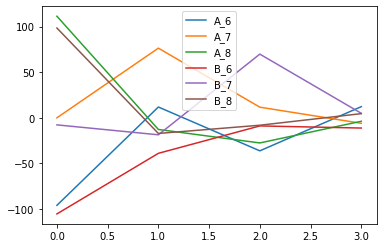

In [6]:
for idx, i in enumerate(['A_6', 'A_7', 'A_8', 'B_6', 'B_7', 'B_8']):
    plt.plot(np.array(x_slab)[idx], label = i)
plt.legend()
plt.show()

## Generate Adsorbate representations

In [7]:
from pymatgen.core.periodic_table import Element
ads_fea_dict = {}
for ele in ['H', 'O', 'Cl']:
    ads_fea_dict[ele] = [getattr(Element(ele), n) for n in ['atomic_radius_calculated', 'van_der_waals_radius', 'Z', 'boiling_point', 'melting_point', 'group', 'row']]
ads_fea_dict

{'H': [0.53, 1.1, 1, 20.28, 14.01, 1, 1],
 'O': [0.48, 1.52, 8, 90.2, 54.8, 16, 2],
 'Cl': [0.79, 1.75, 17, 239.11, 171.6, 17, 3]}

## Generate Group and period based coordination atom fingerprint

In [8]:
    
db_path = "data/training_0516.pkl"
with open(db_path, 'rb') as file_handle:
     db = pickle.load(file_handle)
y = np.array([n['energy'] for n in db])

inner_fingerprinter = coordination_features.InnerShellFingerprinter(features = fea,elements = elements_list, adsorbate='O')
outer_fingerprinter = coordination_features.NextNearestFingerprinter(features = fea,elements = elements_list, adsorbate='O')
caf = coordination_features.StackedFingerprinter(inner_fingerprinter, outer_fingerprinter)

X = caf.fit_transform(db)

pca_caf = PCA(n_components=20)
X  = pca_caf.fit_transform(X)

y = np.array([n['energy'] for n in db])
num_samples = len(X)
num_feats = len(fea)

## Combine slab, adsorbate and coordination fingerprints

In [9]:
X_slab = np.array([x_slab_dict[n['slab']] for n in db])
X_ads = np.array([ads_fea_dict[n['adsorbate']] for n in db])
X_all = np.hstack((X, X_slab, X_ads))
X_all = StandardScaler().fit_transform(X_all)

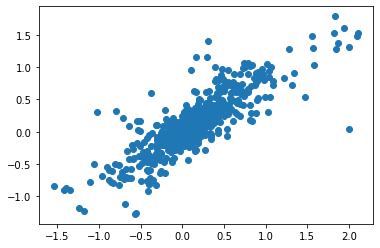

0.1908822722110246


In [10]:
df = pd.DataFrame(np.zeros((len(X_all), 2)))
df.columns = ['true', 'pred']
kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X_all[train_index]
    y_train = y[train_index]
    X_test = X_all[test_index]
    y_test = y[test_index]
    krr = KernelRidge(alpha=0.01, gamma=0.03125, kernel='rbf')
    krr.fit(X_train, y_train)
    y_pred = krr.predict(X_test)
    df.loc[test_index, 'pred'] = y_pred
    df.loc[test_index, 'true'] = y_test

plt.scatter(df['true'], df['pred'])
plt.show()
print((df['true'] - df['pred'] ).abs().mean())